### The SIS model and epidemic thresholds

In this notebook we examine the *Susceptible-Infectious-Susceptible* (SIS) model of epidemiology.
The SIS model describes how an infectious disease spreads on a contact network of people.
Each node in this network represents a person and can be either susceptible (S) or infectious (I).
If a susceptible node has an infectious neighbor, it becomes infectious itself at a certain rate (infection rate).
An infectious node becomes susceptible again at the recovery rate, which we set to $1$.

Hence, the SIS model is a special case of the CNVM. It is given by the rate parameters
$$ r = \begin{pmatrix} - & \lambda \\ 0 & - \end{pmatrix}, \quad \tilde{r} = \begin{pmatrix} - & 0 \\ 1 & - \end{pmatrix}. $$
Typically, the parameter $\alpha$ of the CNVM is set to $0$ in the SIS model, which means that the rate at which a susceptible node gets infected scales linearly with the number of infectious neighbors.
However, for simplicity we will use the default $\alpha = 1$ in this notebook.

Let us start by doing the necessary imports and defining the model.

In [1]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

from netspreadsim import CNVMParameters, CNVM
from netspreadsim.collective_variables import OpinionShares
from netspreadsim import sample_many_runs, calc_rre_traj


In [2]:
num_opinions = 2  # opinion 1 represents 'S', opinion 2 represents 'I'
num_agents = 1000
infection_rate = 0.5

r = np.array(
    [[0, infection_rate],
     [0, 0]]
)
r_tilde = np.array(
    [[0, 0],
     [1, 0]]
)

network = nx.erdos_renyi_graph(num_agents, p=0.1)

params = CNVMParameters(
    num_opinions=num_opinions,
    network=network,
    r=r,
    r_tilde=r_tilde,
)

model = CNVM(params)
cv = OpinionShares(num_opinions, normalize=True)  # for measuring the percentage of infectious nodes

The behavior of the SIS model heavily depends on the underlying network structure.
We have chosen a random Erdös-Renyi graph in this example because it is well understood.

Now we define the simulation parameters, let the model run, and plot the results.
We start with 30% infectious nodes and plot the evolution of the share of infectious nodes.

In [3]:
t_max = 100
x_init = np.zeros(num_agents)  # initial state
x_init[:int(num_agents * 0.3)] = 1
np.random.shuffle(x_init)

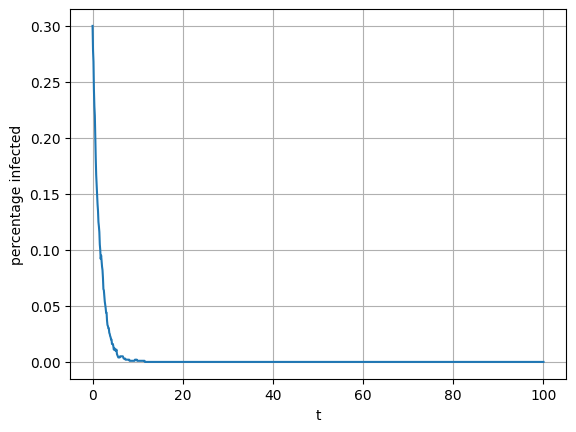

In [4]:
t, x = model.simulate(t_max=t_max, x_init=x_init, len_output=10 * t_max)
c = cv(x)  # calculate the share of infectious nodes

plt.plot(t, c[:, 1])
plt.grid()
plt.xlabel("t")
plt.ylabel("percentage infected")
plt.show()

The above plot shows that the disease dies out quickly. After a short time all the nodes have state (S).
This is because the infection rate was rather small ($\lambda=0.5$).
Let us investigate the dynamics for a larger infection rate of $\lambda=2$.


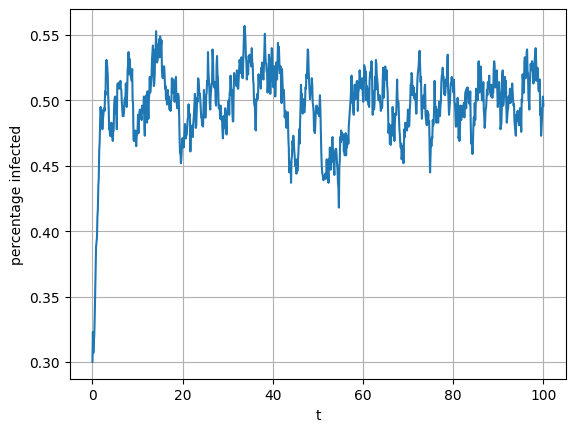

In [5]:
infection_rate = 2
r = np.array(
    [[0, infection_rate],
     [0, 0]]
)
model.update_rates(r=r)

t, x = model.simulate(t_max=t_max, x_init=x_init, len_output=10 * t_max)
c = cv(x)

plt.plot(t, c[:, 1])
plt.grid()
plt.xlabel("t")
plt.ylabel("percentage infected")
plt.show()

Now the disease did not die out. After a short transient phase, the percentage of infectious nodes stabilizes at around 50%.

Let us conduct a statistical analysis of this behavior for different infection rates.
In the following code block we perform many simulations of the SIS model.
(If this takes too long on your machine, try reducing the number of samples by modifying the `num_runs` parameter.)

In [6]:
infection_rates = [0.8, 0.9, 1.0, 1.1, 1.2]
c_results = []
for i_r in infection_rates:
    r = np.array([[0, i_r], [0, 0]])
    params.change_rates(r=r)
    t, c = sample_many_runs(
        params=params,
        initial_states=np.array([x_init]),
        t_max=t_max,
        num_timesteps=t_max,
        num_runs=100,
        collective_variable=cv,
        n_jobs=-1,
    )
    c_results.append(c)

We plot the average share of infectious nodes and the probability that the disease survived up to time $t=100$ (i.e., there is at least one infectious node present).

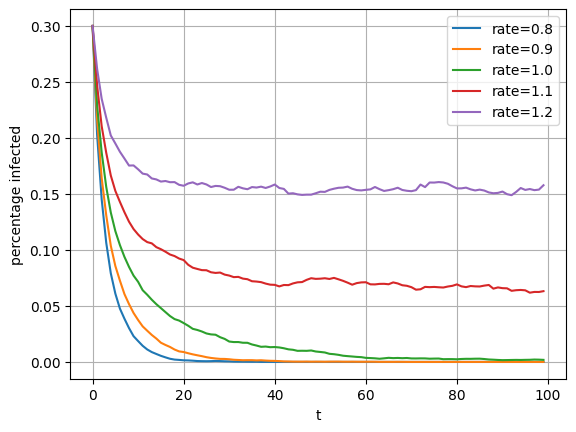

In [7]:
for i_r, c_r in zip(infection_rates, c_results):
    plt.plot(np.mean(c_r[0, :, :, 1], axis=0), label=f"rate={i_r}")
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("percentage infected")
plt.show()

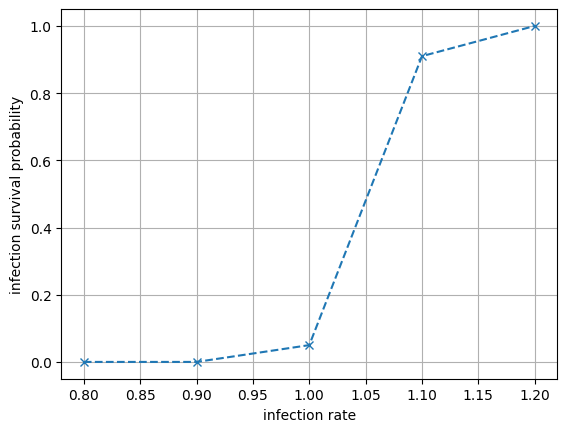

In [8]:
persistence_probabilities = [
    np.linalg.norm(c_r[0, :, -1, 1], 0) / c_r.shape[1] for c_r in c_results
]

plt.plot(infection_rates, persistence_probabilities, "--x")
plt.ylabel("infection survival probability")
plt.xlabel("infection rate")
plt.grid()
plt.show()

Apparently, the disease will likely die out if the infection rate is below 1, and will likely persist if the infection rate is above 1.
This critical value is called the *epidemic threshold*.

For this example (the SIS model on a sufficiently dense Erdös-Renyi random graph) it is known that the evolution of the share of infectious nodes $c(t)$ is given by the following mean-field ODE in the large population limit:
$$ \frac{d}{dt} c(t) = -c(t) + \lambda (1 - c(t)) c(t). \qquad \text{(reaction-rate equation (RRE))} $$
(See the notebook `mean_field.ipynb` or the paper [[Lücke et al., 2022]](https://arxiv.org/abs/2210.02934) for further information about the RRE.)

The plot below shows that this ODE is already reasonably accurate for our finite size network.

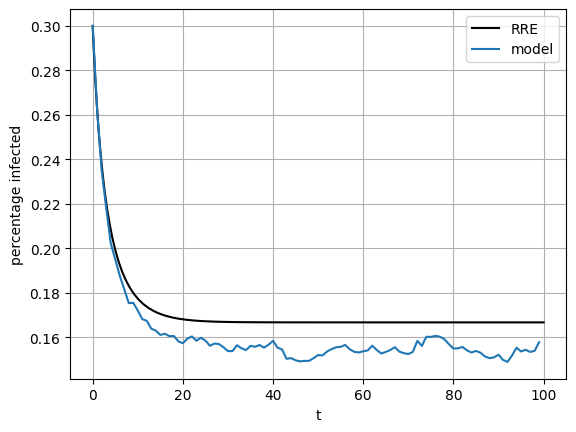

In [9]:
t_rre, c_rre = calc_rre_traj(params, c_results[-1][0, 0, 0], t_max)

plt.plot(t_rre, c_rre[:, 1], "-k", label="RRE")
plt.plot(np.mean(c_results[-1][0, :, :, 1], axis=0), label="model")
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("percentage infected")
plt.show()

The dynamics given by the RRE exhibits a so-called *transcritical bifurcation* as the parameter $\lambda$ crosses the critical value $\lambda_c = 1$:
- For $\lambda < \lambda_c$ the equilibrium $c=0$ is stable and hence the disease always dies out.
- For $\lambda > \lambda_c$ the equlibrium $c=0$ is unstable, but the equilibirum $c_\infty = (\lambda - 1)/\lambda$ is stable. Thus the disease will prevail and the share of infectious nodes converges to $c_\infty$.

In this notebook we have examined the SIS model on a random network using the CNVM package.
We have found that in this system an *epidemic threshold* occurs, i.e., there is a critical infection rate that separates the regimes of the disease dying out and surviving.